<a href="https://colab.research.google.com/github/lsteffenel/M2Atmo_et_Climat/blob/main/07b-MNIST_regression_avec_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Construire un mod√®le de r√©seaux de neurones dense (DNN) avec Keras pour la r√©gression

Nous avons d√©j√† vu comment utiliser un r√©seau dense avec Keras pour la classification du dataset MNIST. Une variante de cet exercice est celui de construire un r√©seau pour la r√©gression : au lieu de pr√©dire la classe d'une image, nous allons essayer d'obtenir une valeur proche de celle du "label" associ√©e √† l'image.

Cet exemple est, bien s√ªr, tr√®s na√Øf car les pr√©dictions seront difficilement exactes. Mais c'est un exemple qui peut s'appliquer √† d'autres datasets, comme par exemple essayer de pr√©dire le niveau de pr√©cipitation √† partir d'une image radar.

Dans les prochains paragraphes vous trouverez presque toutes les commandes d√©j√† utilis√©es pour l'exemple de classification. Faites attention aux modifications qui ont √©t√© faites pour transformer le probl√®me en r√©gression.

In [2]:
import tensorflow as tf

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras

import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import numpy as np
print (tf.__version__)
print(keras.__version__)


2.17.1
3.5.0


## Chargement de donn√©es

Tout comme Scikit-Learn, Keras a aussi un ensemble de datasets pr√™t √† utilisation pour des exemples. Dans le cas suivant, nous allons charger le dataset MNIST (√©criture √† la main) et le s√©parer en deux groupes : Train et Test. Les donn√©es de validation (v√©rification pendant l'entra√Ænement) seront s√©par√©s du groupe Train plus tard.

In [3]:
from keras.datasets import mnist

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 0us/step


In [4]:
x_train.shape
x_test.shape
y_test.shape

(10000,)

In [5]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Les donn√©es de MNIST se pr√©sentent sous la forme d'images 28x28 pixels, avec 256 tons de gris. Les labels (`y_train`, par exemple) correspondent aux caract√®res repr√©sent√©s : les chiffres 0 √† 9.

Le paragraphe suivant d√©finit une fonction permettant de visualiser ce dataset.

In [6]:
def plot_images(x,y=None, indices='all', columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm='binary', norm=None, y_padding=0.35, spines_alpha=1,
                fontsize=20, interpolation='lanczos', save_as='auto'):
    """
    Show some images in a grid, with legends
    args:
        x             : images - Shapes must be (-1,lx,ly) (-1,lx,ly,1) or (-1,lx,ly,3),(-1,1,lx,ly) or (-1,3,lx,ly)
        y             : real classes or labels or None (None)
        indices       : indices of images to show or 'all' for all ('all')
        columns       : number of columns (12)
        x_size,y_size : figure size (1), (1)
        colorbar      : show colorbar (False)
        y_pred        : predicted classes (None)
        cm            : Matplotlib color map (binary)
        norm          : Matplotlib imshow normalization (None)
        y_padding     : Padding / rows (0.35)
        spines_alpha  : Spines alpha (1.)
        font_size     : Font size in px (20)
        save_as       : Filename to use if save figs is enable ('auto')
    returns:
        nothing
    """
    if indices=='all': indices=range(len(x))
    if norm and len(norm) == 2: norm = matplotlib.colors.Normalize(vmin=norm[0], vmax=norm[1])
    draw_labels = (y is not None)
    draw_pred   = (y_pred is not None)
    # Torch Tensor ?
    if y.__class__.__name__      == 'Tensor': y=y.numpy()
    if y_pred.__class__.__name__ == 'Tensor': y_pred=y_pred.detach().numpy()

    rows        = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+y_padding)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        # ---- Shape is (lx,ly)
        if len(x[i].shape)==2:
            xx=x[i]
        # ---- Shape is (lx,ly,c) or (c,lx,ly)
        if len(x[i].shape)==3:
            if x[i].__class__.__name__ == 'Tensor':
               (c,lx,ly)=x[i].shape
               if c==1:
                   xx=x[i].permute(1,2,0).numpy().reshape(lx,ly)
               else:
                   xx=x[i].permute(1,2,0).numpy() #---> (lx,ly,n)
            else:
                (lx,ly,c)=x[i].shape
                if c==1:
                    xx=x[i].reshape(lx,ly)
                else:
                    xx=x[i]

        img=axs.imshow(xx,   cmap = cm, norm=norm, interpolation=interpolation)
        axs.spines['right'].set_visible(True)
        axs.spines['left'].set_visible(True)
        axs.spines['top'].set_visible(True)
        axs.spines['bottom'].set_visible(True)
        axs.spines['right'].set_alpha(spines_alpha)
        axs.spines['left'].set_alpha(spines_alpha)
        axs.spines['top'].set_alpha(spines_alpha)
        axs.spines['bottom'].set_alpha(spines_alpha)
        axs.set_yticks([])
        axs.set_xticks([])
        if draw_labels and not draw_pred:
            axs.set_xlabel(y[i],fontsize=fontsize)
        if draw_labels and draw_pred:
            if y[i]!=y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})',fontsize=fontsize)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i],fontsize=fontsize)
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    plt.show()



Nous allons donc afficher l'un des caract√®res du groupe Train (celui √† la position 27) mais aussi tout la plage entre les donn√©es 5 et 41. Remarquez le "label" correspondant sous chaque image.

3


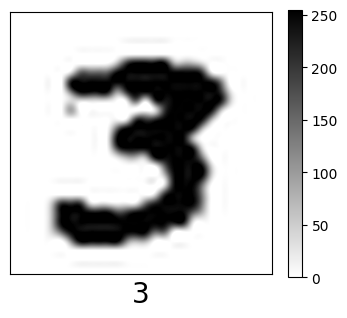

In [7]:
print(y_train[27])
plot_images(x_train, y_train, indices=[27],  x_size=5,y_size=5, colorbar=True)


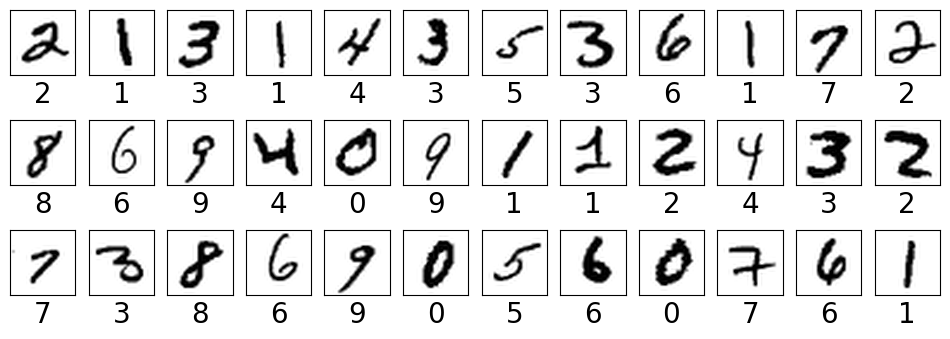

In [8]:
plot_images(x_train, y_train, range(5,41), columns=12)

**1 - Normalisation des donn√©es**

Les valeurs de base son des entiers entre 0 et 255 pour repr√©senter les 256 tons de gris. La majorit√© des algorithmes utilisent des valeurs r√©els, de pr√©f√©rence dans la fourchette 0 √† 1 ou -1 √† 1.

Les paragraphes suivantes modifient le type des donn√©es (`float32`) puis font une normalisation simple (diviser la valeur par `max`, qui dans ce cas do√Æt √™tre de 255). Bien s√ªr, d'autres m√©thodes de normalisation plus √©labor√©es sont possibles, mais √ßa suffit pour l'instant.

In [28]:
x_train = x_train.astype('float16')
x_test = x_test.astype('float16')
y_train = y_train.astype('float16')
y_test = y_test.astype('float16')

In [29]:
print('Before normalization : Min={}, max={}'.format(x_train.min(),x_train.max()))

xmax=x_train.max()
x_train = x_train / xmax
x_test  = x_test  / xmax

print('After normalization  : Min={}, max={}'.format(x_train.min(),x_train.max()))

Before normalization : Min=0.0, max=1.0
After normalization  : Min=0.0, max=1.0


**3 - Labels**

Contrairement √† l'exemple de classification, cette fois-ci nous utiliserons les labels comme de valeurs cible √† estimer.

## La Cr√©ation d'un mod√®le

Keras a plusieurs modes permettant la cr√©ation de mod√®les de r√©seaux de neurones. Dans ce cas, nous allons utiliser l'API `Sequential` qui permet de d√©crire couche par couche du r√©seau et les empiler (gr√¢ce √† `add()`).

Nous allons faire un mod√®le simple avec des r√©seaux denses (totalement connect√©s). La premi√®re couche d√©finit la taille de l'entr√©e (les 784 valeurs re√ßus du dataset), les autres utilisent par d√©faut la taille de la sortie de la couche pr√©c√©dente.

La diff√©rence est que nous utiliserons un seul neurone en sortie, avec l'activation "Linear". Cela veut dire que nous allons simplement obtenir la valeur pond√©r√©e des neurones, au lieu d'avoir une liste de probabilit√©s pour 10 classes.

In [30]:
from keras import Sequential
from keras import layers
from keras import optimizers

# Declaration du mod√®le en Keras
model = keras.Sequential()
model.add(layers.Input((28,28)))
model.add(layers.Flatten())
model.add(layers.Dense(30, activation='sigmoid'))
model.add(layers.Dense(20, activation='sigmoid'))
model.add(layers.Dense(1, activation='linear'))


# r√©sum√© du mod√®le
model.summary()



Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ flatten_1 (Flatten)                  ‚îÇ (None, 784)                 ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)                      ‚îÇ (None, 30)                  ‚îÇ          23,550 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_4 (Dense)                      ‚îÇ (None, 20)                  ‚îÇ             620 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_5 (Dense)                      ‚îÇ (None, 1)                   ‚îÇ              21 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 24,191 (94.50 KB)

 Trainable params: 24,191 (94.50 KB)

 Non-trainable params: 0 (0.00 B)

## Entra√Ænement du mod√®le

Une fois d√©fini le mod√®le, il faut l'entra√Æner avec les donn√©es.
Le paragraphe suivant d√©finit les hyperparam√®tres du mod√®le, dont le `batch_size`(taille des sous-ensembles utilis√©s dans la descente de gradient), le nombre d'epochs (parcours de l'ensemble de donn√©es d'entra√Ænement).

L'appel √† compile g√©n√®re le graphe d'ex√©cution (un r√©seau de neurones = un graphe) et indique aussi qu'on utilise le mod√®le de descente de gradient SGD, que la m√©trique utilis√©e est l'accuracy (m√©trique qui correspond √† (TP+TN)/(TP+TN+FP+FN)), et que la fonction de perte est la `categorical_crossentropy`, une fonction qui compare les probabilit√©s pour des labels cat√©goriques.

In [31]:
batch_size = 100
#num_classes = 10
epochs= 20

model.compile(loss='mse',  optimizer='Adam',  metrics=['mse'])


Finalement, on lance l'entra√Ænement. Remarquez aussi qu'on n'a pas cr√©e des donn√©es Validation avant, on le fera **sur place** en r√©servant 10% des donn√©es de Train (appel √† `validation_split=0.1`).

Comme le dataset est simple, on peut faire l'entra√Ænement m√™me sans un GPU.

In [32]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,verbose=1 )

#verbose: Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
# Je vous invite √† lire la documentation : https://keras.io/models/sequential/

Epoch 1/20
540/540 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 3ms/step - loss: 9.0535 - mse: 9.0535 - val_loss: 2.9802 - val_mse: 2.9802
Epoch 2/20
540/540 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - loss: 2.9340 - mse: 2.9340 - val_loss: 1.8412 - val_mse: 1.8412
Epoch 3/20
540/540 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - loss: 1.9291 - mse: 1.9291 - val_loss: 1.3474 - val_mse: 1.3474
Epoch 4/20
540/540 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - loss: 1.4585 - mse: 1.4585 - val_loss: 1.0726 - val_mse: 1.0726
Epoch 5/20
540/540 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - loss: 1.2225 - mse: 1.2225 - val_loss: 0.9723 - val_mse: 0.9723
Epoch 6/20
540/540 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - loss: 1.0839 - mse: 1.0839 - val_loss: 0.8692 - val_mse: 0.8692
Epoch 7/20
540/540 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Les paragraphes suivants nous permettent de voir comment le mod√®le am√©liore sa performance au fil des epochs

In [18]:
def plot_history(history, figsize=(8,6),
                 plot={"Accuracy":['mse','val_mse'], 'Loss':['loss', 'val_loss']}):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history.history[c])
        plt.legend(curves, loc='upper left')

        plt.show()

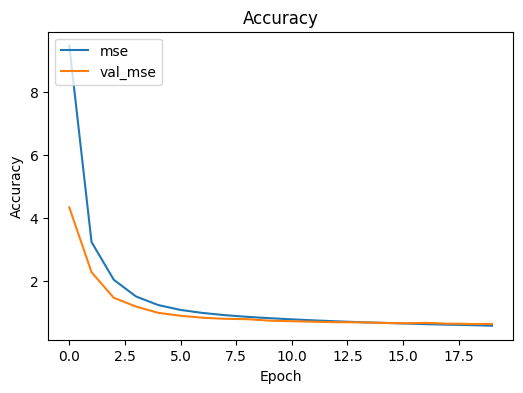

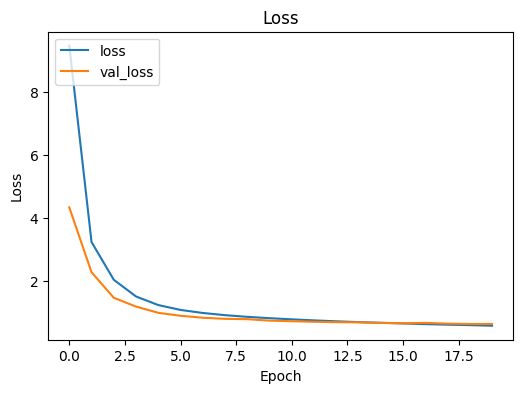

In [19]:
plot_history(history, figsize=(6,4))

Enfin, on peut estimer la performance du mod√®le avec les donn√©es Test.

Comparez ces valeur avec ceux de l'entra√Ænement (`val_loss` et `val_mse`
 ci-dessus). Comme la m√©trique MSE est "le carr√© de l'erreur", on fait √©galement la RMSE pour avoir une id√©e de l'erreur moyenne sur les estimations.

In [34]:
import math
test_loss, test_mse = model.evaluate(x_test, y_test,verbose=0)

print('Test loss:', test_loss)
print('Test mse:', test_mse)
print('Test rmse:', math.sqrt(test_mse))

Test loss: 0.7845431566238403
Test mse: 0.7845431566238403
Test rmse: 0.8857444081809607


Ces r√©sultats montrent que, √©tonemment, le mod√®le se porte mieux avec le groupe de validation (val_accuracy), c'est int√©ressant üëç.

## Quelques erreurs

Si vous avez fait attention, on n'a toujours pas touch√© le dataset `x_test/y_test`, vu qu'on a fait l'entra√Ænement avec 90% et valid√© avec 10% du x_train.

On peut donc utiliser x_test comme "nouvelle donn√©e" et v√©rifier si notre mod√®le rend bien les r√©ponses.

Dans le prochain paragraph, nous allons donc produire une estimation `y_pred` √† partir de `x_test`. La sortie du mod√®le est une valeur r√©elle, qui sera au pire "proche" de la valeur de l'image.

In [35]:
# d'abord, on utilise le mod√®le pour faire une pr√©vision sur l'ensemble de test
# √áa retourne une liste avec 10 colonnes (une par sortie possible).
y_pred = model.predict(x_test)


313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step


Maintenant, on affiche quelques √©l√©ments, avec la valeur pr√©dite et la valeur attendue (entre parenth√®ses). Au del√† de l'erreur d'approximation (ex : 1.244 pour un 1), on trouve √©galement des erreurs d'identification (sur la derni√®re ligne il y a un 9 qui a √©t√© incorrectement identifi√© comme un 7).

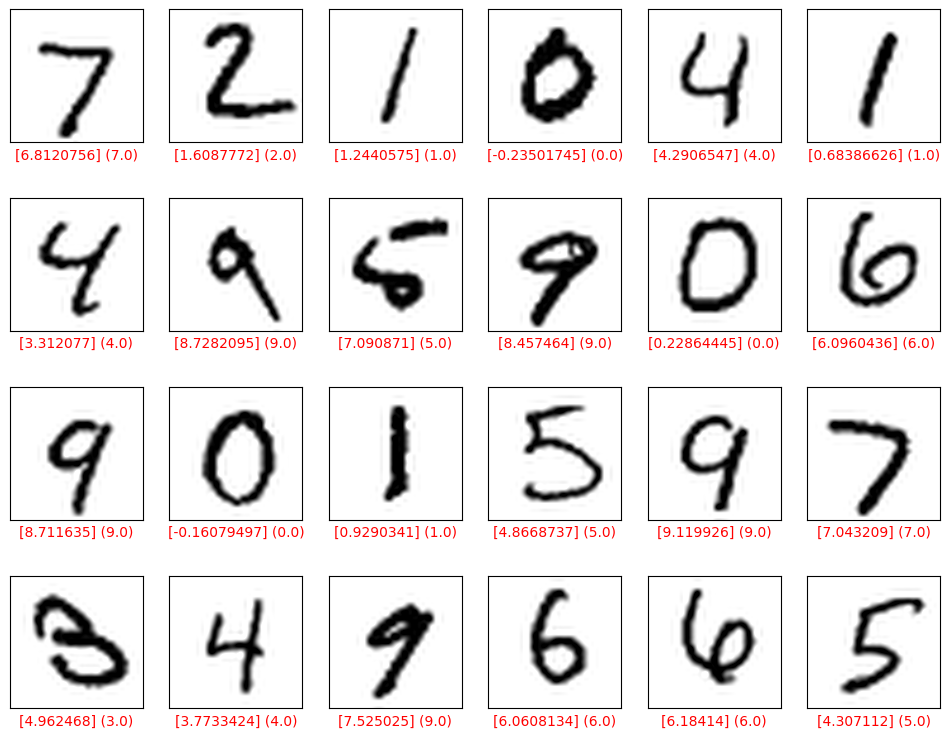

In [38]:


plot_images(x_test, y_test, range(0,24), columns=6, x_size=2, y_size=2, y_pred=y_pred,fontsize=10)

## Exercice :
Essayez de r√©duire l'erreur. Comme pour la classification, changez les fonctions d'activation, le nombre de neurones, le nombre de couches...

